## Setup

In [69]:
import pandas as pd
import re
import requests
from scipy.stats import poisson
import math
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt
import json
import os
from urllib.parse import quote_plus
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from collections import defaultdict
import nltk, re, pprint
from nltk import word_tokenize
import community
import powerlaw
from nltk import FreqDist 
import numpy as np
import random

%matplotlib inline

In [25]:
table_counter = 1
figure_counter = 1

# Part 0: Building the network

## Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.

**Answer:** 

Since we have already downloaded all rappers pages and a csv file with rappers distinguished by coasts, we go through each rapper in the csv file and find the correspondent wikipedia file. To do this we had to transform the name of the rapper to a readable format that coincide to the name of the file.

For each wikipedia file we search for the names inside brackets `[[  ]]`, which corresponds to the connections inside a wikipedia page (hyperlinks).

After getting the content between the brackets, we faced the problem of having inside the same bracket two names, the one with interest was the first that appeared. E.g.: ['Hip hop music|Hip hop'], we only want 'Hip hop music'. Those names are seperated by a `|` (pipe) symbol.

To get rid of all hyperlinks, which are not leading to another rapper, we check if the target of the hyperlink is in the rappers-list.

## Show the regular expressions you have built and explain in details how they work.

 **Answer:**  
   
 The Regular Expression we have used is as follows: `r'\[\[(.*?)(?:\||\]\])'`

This regular expression is designed to match and capture text within double square brackets `[[ ]]`, stopping at the first occurrence of a pipe `|` or the closing double square brackets.

- `\[`: Matches a literal `[` character.
- `\[\[`: Matches the string `[[`.
- `(.*?)`: Captures any character (.) as few times as possible (*?), making a non-greedy match.
- `(?:\||\]\])`: A non-capturing group matching either a `|` character or the string `]]`.

[1]


# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

In [11]:
# Code to create the Network, extract the  largest connected component and save it as a file 
# we include this to show how we created the network, if someone wants to run notebook without having the files.

def get_wikipedia_content(title):
    baseurl = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": title
    }
    response = requests.get(baseurl, params=params).json()
    page = next(iter(response["query"]["pages"].values()))
    content = page["revisions"][0]["*"]
    return content

def get_links_and_content(wikipedia_titles):
    links_dict = {}
    content_dict = {}
    for title in wikipedia_titles:
        content = get_wikipedia_content(title)
        links = re.findall(r'\[\[(.*?)(?:\||\]\])', content)
        links_dict[title] = links
        content_dict[title] = content
    return links_dict, content_dict

def build_graph(links_dict, all_rappers_set):
    G = nx.DiGraph()
    G.add_nodes_from(all_rappers_set)
    for rapper, links in links_dict.items():
        valid_links = set(links) & all_rappers_set
        G.add_edges_from((rapper, link) for link in valid_links)
    return G

EastCoast = pd.read_csv("EastCoastRappers.csv")
WestCoast = pd.read_csv("WestCoastRappers.csv")

toprapper_east = EastCoast.WikipediaPageName.tolist()
toprapper_west = WestCoast.WikipediaPageName.tolist()
all_rappers_set = set(toprapper_east + toprapper_west)

east_links_dict, east_content_dict = get_links_and_content(toprapper_east)
west_links_dict, west_content_dict = get_links_and_content(toprapper_west)

all_links_dict = {**east_links_dict, **west_links_dict}
all_content_dict = {**east_content_dict, **west_content_dict}

Graph_rapper = build_graph(all_links_dict, all_rappers_set)

largest_cc_rapper = max(nx.weakly_connected_components(Graph_rapper), key=len)
Graph_rapper_lcc = Graph_rapper.subgraph(largest_cc_rapper)

for node in Graph_rapper_lcc.nodes():
    Graph_rapper_lcc.nodes[node]["coast"] = "east" if node in toprapper_east else "west"
    Graph_rapper_lcc.nodes[node]["length"] = len(re.findall(r'\b\w+\b', all_content_dict[node]))
    Graph_rapper_lcc.nodes[node]["content"] = all_content_dict[node]

nx.write_gexf(Graph_rapper_lcc, "rapper_graph.gexf")

## Exercise 1a: Stats (see lecture 4 and 5 for more hints)

In [15]:
# Load the graph
G = nx.read_gexf("rapper_graph.gexf")

# 1. Number of nodes
num_nodes = G.number_of_nodes()

# 2. Number of links
num_links = G.number_of_edges()

# 3. Top connected rapper
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
top_rapper_in = max(in_degrees, key=in_degrees.get)
top_rapper_out = max(out_degrees, key=out_degrees.get)


# 4. Top 5 most connected east-coast rappers
east_coast_rappers = [n for n, d in G.nodes(data=True) if d['coast'] == 'east']
east_coast_in_degrees = {rapper: in_degrees[rapper] for rapper in east_coast_rappers}
east_coast_out_degrees = {rapper: out_degrees[rapper] for rapper in east_coast_rappers}
top_5_east_coast_in = sorted(east_coast_in_degrees, key=east_coast_in_degrees.get, reverse=True)[:5]
top_5_east_coast_out = sorted(east_coast_out_degrees, key=east_coast_out_degrees.get, reverse=True)[:5]

# 5. Top 5 most connected west-coast rappers
west_coast_rappers = [n for n, d in G.nodes(data=True) if d['coast'] == 'west']
west_coast_in_degrees = {rapper: in_degrees[rapper] for rapper in west_coast_rappers}
west_coast_out_degrees = {rapper: out_degrees[rapper] for rapper in west_coast_rappers}
top_5_west_coast_in = sorted(west_coast_in_degrees, key=west_coast_in_degrees.get, reverse=True)[:5]
top_5_west_coast_out = sorted(west_coast_out_degrees, key=west_coast_out_degrees.get, reverse=True)[:5]

# 6. Plot the in- and out-degree distributions
in_degree_values = sorted([d for n, d in G.in_degree()], reverse=True)
out_degree_values = sorted([d for n, d in G.out_degree()], reverse=True)

# 7. Find the exponent for the in- and out-degree distributions
fit_in = powerlaw.Fit(np.array(in_degree_values) + 1)
fit_out = powerlaw.Fit(np.array(out_degree_values) + 1)
exponent_in = fit_in.power_law.alpha
exponent_out = fit_out.power_law.alpha

# 8. Degree distribution of a random network
p = num_links / (num_nodes * (num_nodes - 1))
random_G = nx.erdos_renyi_graph(num_nodes, p)
random_degrees = sorted([d for n, d in random_G.degree()], reverse=True)

# Display the results
results = pd.DataFrame.from_dict({
    "Metric": ["Number of Nodes", "Number of Links", "Top Rapper (In-Degree)", "Top Rapper (Out-Degree)",
               "Top 5 East Coast Rappers (In-Degree)", "Top 5 East Coast Rappers (Out-Degree)",
               "Top 5 West Coast Rappers (In-Degree)", "Top 5 West Coast Rappers (Out-Degree)",
               "In-Degree Exponent", "Out-Degree Exponent"],
    "Value": [num_nodes, num_links, top_rapper_in, top_rapper_out,
              top_5_east_coast_in, top_5_east_coast_out,
              top_5_west_coast_in, top_5_west_coast_out,
              exponent_in, exponent_out]
})
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

results


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


,Metric,Value
0,Number of Nodes,728
1,Number of Links,5829
2,Top Rapper (In-Degree),Snoop Dogg
3,Top Rapper (Out-Degree),Drag-On
4,Top 5 East Coast Rappers (In-Degree),"[Jay-Z, Nas, 50 Cent, Busta Rhymes, The Notorious B.I.G.]"
5,Top 5 East Coast Rappers (Out-Degree),"[Drag-On, Black Thought, Jahlil Beats, MC Lyte, Uncle Murda]"
6,Top 5 West Coast Rappers (In-Degree),"[Snoop Dogg, Dr. Dre, Kendrick Lamar, Tupac Shakur, E-40]"
7,Top 5 West Coast Rappers (Out-Degree),"[DJ Dahi, Kendrick Lamar, The Game (rapper), Dr. Dre, Kurupt]"
8,In-Degree Exponent,2.812118
9,Out-Degree Exponent,12.091138


* Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

* What is the number of nodes in the network?
   * The number of nodes in the network is **728**.


* What is the number of links?
   * The number of links in the network is **5828**.


* Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
   * The top rapper based on in-degrees is **Snoop Dogg**.
   * The top rapper based on out-degrees is **Drag-On**.
   * Comment: Snoop Dogg being the top-connected rapper based on in-degrees is unsurprising given his big influence in the hip-hop industry. An explenation could be, that snoop dog is a role model for a lot of other rappers and therefore they are referencing to him . Drag-On being the top for out-degrees, indicating that he has the most links going out from his Wikipediapage. This could mean, that his Page is very detailed ord that he collaborated with a diverse range of artists and therefore names a lot of different artists.


* Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)?
   * In-Degree: **Jay-Z, Nas, 50 Cent, Busta Rhymes, The Notorious B.I.G.**
   * Out-Degree: **Drag-On, Black Thought, MC Lyte, Jahlil Beats, DJ Premier**.


* Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
   * In-Degree: **Snoop Dogg, Dr. Dre, Kendrick Lamar, Tupac Shakur, E-40**.
   * Out-Degree: **DJ Dahi, The Game (rapper), Kendrick Lamar, Dr. Dre, Kurupt**.


* Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
   * In-Degree Exponent: **2.814131**.
   * Out-Degree Exponent: **12.091138**.
   * Comment: The exponents indicate the steepness of the decline in the number of nodes with a particular degree as the degree increases. Smaller exponent values suggest that there are more nodes with higher degrees. The observed values, especially for out-degrees, suggest a network that has a very skewed distribution, with few nodes having very high out-degrees.

* Plot the in- and out-degree distributions for the whole network. 
  * Use axes that make sense for visualizing this particular distribution.
  * What do you observe? 
  * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?

In [ ]:
# plot the In-Degree and Out-Degree Distributions

plt.figure(figsize=(10, 5))
plt.loglog(in_degree_values, 'b-', marker='o', label='In-Degree')
plt.loglog(out_degree_values, 'r-', marker='o', label='Out-Degree')
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.title('In-Degree and Out-Degree Distributions')
plt.legend()
plt.show()


***Description of the plot***

* Plot the in- and out-degree distributions for the whole network.
   - The plots provided showcase the in-degree and out-degree distributions.
   
   - What do you observe?
     - The in-degree and out-degree distributions follow a power-law distribution, which is common for many real-world networks. There is a small number of nodes (rappers) with high degrees, while most nodes have relatively low degrees.

   - Give a pedagogical explanation of why the in-degree distribution is different from the out-degree distribution?
     - **??? Maybe something with the friendship paradox ???**
     - **or because some wikipages are longer than other ?**

In [ ]:
#plot the Degree Distribution of a Random Network

plt.figure(figsize=(10, 5))
plt.loglog(random_degrees, 'g-', marker='o', label='Random Network')
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.title('Degree Distribution of a Random Network')
plt.legend()
plt.show()

***Description of the plot***

* Compare the two degree distributions to the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.
   - The provided random network degree distribution plot can be compared to the in-degree and out-degree distributions. 
   - Comment: The random network shows a more even distribution, suggesting that most nodes have a similar number of connections. This is in stark contrast to the observed power-law distributions for the in- and out-degrees in the rap network. The rap network has a few highly connected nodes, whereas in a random network, connections are more uniformly distributed. This showcases the uniqueness of real-world networks compared to theoretical random networks.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

In [ ]:
from fa2 import ForceAtlas2

#node color
node_colors = []


for key, value in nx.get_node_attributes(G, 'coast').items():
    if value == 'east':
        node_colors.append('blue')
    elif value == 'west':
        node_colors.append('red')
    else:
        node_colors.append('gray')


# node size 
node_sizes = [G.degree(node) * 1.5 for node in G.nodes()]

#color of the edge is based on the coast of the source node
edge_color_list = []
for edge in G.edges():
    if G.nodes[edge[0]]["coast"] == "west" and G.nodes[edge[1]]["coast"] == "west":
        edge_color_list.append("red")
    elif G.nodes[edge[0]]["coast"] == "east" and G.nodes[edge[1]]["coast"] == "east":
        edge_color_list.append("blue")
    else:
        edge_color_list.append("black")

#position
# create a ForceAtlas2 object
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=10.0,
                        strongGravityMode=False,
                        gravity=0.15,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

nx.draw_networkx_nodes(G, positions, node_size=node_sizes, node_color=node_colors, alpha=0.4)
nx.draw_networkx_edges(G, positions, alpha=0.05, edge_color = edge_color_list)
plt.axis('off')
plt.show() 

**Describe the plot and adjust it maybe ???**


# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [ ]:
# Add the code from the supporting notebook here 


In [ ]:
rapper_tokens_west = pd.read_csv('rapper_tokens_west.csv', header=None).iloc[0].tolist()
rapper_tokens_east = pd.read_csv('rapper_tokens_east.csv', header=None).iloc[0].tolist()


**cleaning of the corpus**
- Remove all punctuation from your list of tokens

- Set everything to lower case

- Lemmatize your words

In [ ]:
# count the frequency of each token in the text 
from nltk.probability import FreqDist

fdist_west = FreqDist(rapper_tokens_west)
fdist_east = FreqDist(rapper_tokens_east)

# make dict out of frequency distribution
freq_west = dict(fdist_west)
freq_east = dict(fdist_east)


In [ ]:
# calculate a score for each word in east. The formular is (Tf_w)/(Tf_e + c)
# Tf_w = term frequency in west
# Tf_e = term frequency in east

# create dict with score for each word
score_dict_east = {}
c = 5
for word in freq_east:
    if word in freq_west:
        score_dict_east[word] = freq_east[word]/(freq_west[word]+c)
    else:
        score_dict_east[word] = freq_east[word]/c


# create dict with score for each word
score_dict_west = {}
c = 5
for word in freq_west:
    if word in freq_east:
        score_dict_west[word] = freq_west[word]/(freq_east[word]+c)
    else:
        score_dict_west[word] = freq_west[word]/c



In [ ]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# create wordcloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(score_dict_east)
wordcloud.to_image()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# create wordcloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(score_dict_west)
wordcloud.to_image()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
# sort dict by value
import operator

sorted_score_dict_east = sorted(score_dict_east.items(), key=operator.itemgetter(1), reverse=True)
sorted_score_dict_west = sorted(score_dict_west.items(), key=operator.itemgetter(1), reverse=True)

#print top 10 words
print(sorted_score_dict_east[:5])
print(sorted_score_dict_west[:5])

**Comment on the finding**

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper




In [3]:
labmt=pd.read_csv('Data_Set_S1.txt', delimiter='\t')

In [7]:
def tokenize(text):
    tokens = word_tokenize(text)
    wnl = nltk.WordNetLemmatizer()
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [wnl.lemmatize(word) for word in tokens]
    return tokens

In [8]:
def sentiment(labmt,tokens):

    
    freq_dist = FreqDist(tokens)

    # Calculate sentiment scores for unique words
    sentiment_scores = {}
    
    for word in freq_dist.items():
        matching_word = labmt[labmt['word'] == word]

        if not matching_word.empty:
            sentiment = matching_word['happiness_average'].values[0]
            sentiment_scores[word] = sentiment
 
    total_sentiment = sum(sentiment_scores[word] * freq for word, freq in freq_dist.items() if word in sentiment_scores)
    total_frequency = sum(freq for word, freq in freq_dist.items() if word in sentiment_scores)
    average_sentiment = total_sentiment / total_frequency

     # Create a dictionary with words, frequencies, and happiness scores
    words_dict = {
        word: {
            'frequency': freq,
            'happiness_score': sentiment_scores[word]
        }
        for word, freq in freq_dist.items() if word in sentiment_scores
    }
  

    # Order words by happiness score
    words_dict = dict(sorted(words_dict.items(), key=lambda item: item[1]['happiness_score'], reverse=True))

    return average_sentiment, words_dict

In [16]:
#Create more 2 nodes attributtes to save the average sentiment and the words present in their wikipedia pages, the freqeuncy and the score
for node in G.nodes():
 tokens  = tokenize(G.nodes[node]["content"])
 average_sentiment, words_dict = sentiment(labmt, tokens)
 G.nodes[node]["average_sentiment"] = average_sentiment
 G.nodes[node]["words_dict"] = words_dict
 


> * Create a histogram of all rappers' associated sentiments.


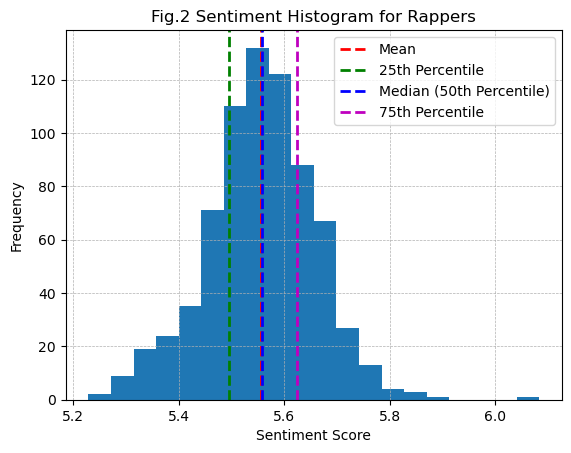

Mean Sentiment: 5.5562231814928325
Percentiles:
25th Percentile: 5.495524363114459
50th Percentile (Median): 5.556768680470302
75th Percentile: 5.622942555476018


In [35]:
# Gather sentiments for all rappers
all_sentiments = [G.nodes[node]['average_sentiment'] for node in G.nodes()]

# Calculate the mean
mean_sentiment = np.mean(all_sentiments)

# Calculate percentiles (e.g., 25th, 50th, and 75th percentiles)
percentiles = np.percentile(all_sentiments, [25, 50, 75])

# Plot the histogram
plt.hist(all_sentiments, bins=20)
plt.title(f'Fig.{figure_counter+1} Sentiment Histogram for Rappers')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add vertical lines for mean and percentiles
plt.axvline(mean_sentiment, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(percentiles[0], color='g', linestyle='dashed', linewidth=2, label='25th Percentile')
plt.axvline(percentiles[1], color='b', linestyle='dashed', linewidth=2, label='Median (50th Percentile)')
plt.axvline(percentiles[2], color='m', linestyle='dashed', linewidth=2, label='75th Percentile')

# Display a legend
plt.legend()

# Show the plot
plt.show()

print(f"Mean Sentiment: {mean_sentiment}")
print("Percentiles:")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

Legend Fig: The Histogram represents the distribution of average hapiness score of all rapper's (west and east coast) wikipedia pages. We can see that the majority of the pages have score between 5.5 and 5.6 (as indicated by the 25th and 75th percentiles), this means that rappers in general have a slightly positive sentiment on average in their Wipedia pages (in the the dictionary labMT we have as lower score 1.3 and higher 8.5)

> * What are the 10 rappers with happiest and saddest pages?

In [62]:
# Create lists to store data for happiest and saddest rappers
happiest_rapper_names = []
happiest_positive_words = []
happiest_positive_frequencies = []
happiest_positive_scores = []
happiest_negative_words = []
happiest_negative_frequencies = []
happiest_negative_scores = []
happiest_overall_scores = []
happiest_text_lengths = []

saddest_rapper_names = []
saddest_positive_words = []
saddest_positive_frequencies = []
saddest_positive_scores = []
saddest_negative_words = []
saddest_negative_frequencies = []
saddest_negative_scores = []
saddest_overall_scores = []
saddest_text_lengths = []

# Find the 10 rappers with happiest and saddest pages
sorted_rappers = sorted(G.nodes(data=True), key=lambda x: x[1]['average_sentiment'], reverse=True)
happiest_rappers = sorted_rappers[:10]
saddest_rappers = sorted_rappers[-10:]

# Extract data for the summary tables
for rapper in happiest_rappers:
    rapper_name = rapper[0]
    rapper_data = rapper[1]

    positive_word_data = sorted(rapper_data['words_dict'].items(), key=lambda x: x[1]['happiness_score'], reverse=True)[:3]
    negative_word_data = sorted(rapper_data['words_dict'].items(), key=lambda x: x[1]['happiness_score'])[:3]

    happiest_rapper_names.append(rapper_name)
    happiest_positive_words.append([word for word, _ in positive_word_data])
    happiest_positive_frequencies.append([info['frequency'] for _, info in positive_word_data])
    happiest_positive_scores.append([info['happiness_score'] for _, info in positive_word_data])
    happiest_negative_words.append([word for word, _ in negative_word_data])
    happiest_negative_frequencies.append([info['frequency'] for _, info in negative_word_data])
    happiest_negative_scores.append([info['happiness_score'] for _, info in negative_word_data])

    # Add the overall average sentiment for the happiest rapper
    happiest_overall_scores.append(rapper_data['average_sentiment'])
    
    # Add text length as a node attribute
    happiest_text_lengths.append(rapper_data['length'])

for rapper in saddest_rappers:
    rapper_name = rapper[0]
    rapper_data = rapper[1]

    positive_word_data = sorted(rapper_data['words_dict'].items(), key=lambda x: x[1]['happiness_score'], reverse=True)[:3]
    negative_word_data = sorted(rapper_data['words_dict'].items(), key=lambda x: x[1]['happiness_score'])[:3]

    saddest_rapper_names.append(rapper_name)
    saddest_positive_words.append([word for word, _ in positive_word_data])
    saddest_positive_frequencies.append([info['frequency'] for _, info in positive_word_data])
    saddest_positive_scores.append([info['happiness_score'] for _, info in positive_word_data])
    saddest_negative_words.append([word for word, _ in negative_word_data])
    saddest_negative_frequencies.append([info['frequency'] for _, info in negative_word_data])
    saddest_negative_scores.append([info['happiness_score'] for _, info in negative_word_data])

    # Add the overall average sentiment for the saddest rapper
    saddest_overall_scores.append(rapper_data['average_sentiment'])
    
    # Add text length as a node attribute
    saddest_text_lengths.append(rapper_data['length'])

# Create tables for happiest and saddest rappers
happiest_rappers_table = pd.DataFrame({
    'Rapper': happiest_rapper_names,
    'Positive Words': happiest_positive_words,
    'Positive Frequencies': happiest_positive_frequencies,
    'Positive Scores': happiest_positive_scores,
    'Negative Words': happiest_negative_words,
    'Negative Frequencies': happiest_negative_frequencies,
    'Negative Scores': happiest_negative_scores,
    'Overall Average Sentiment': happiest_overall_scores,
    'Text Length': happiest_text_lengths
})

saddest_rappers_table = pd.DataFrame({
    'Rapper': saddest_rapper_names,
    'Positive Words': saddest_positive_words,
    'Positive Frequencies': saddest_positive_frequencies,
    'Positive Scores': saddest_positive_scores,
    'Negative Words': saddest_negative_words,
    'Negative Frequencies': saddest_negative_frequencies,
    'Negative Scores': saddest_negative_scores,
    'Overall Average Sentiment': saddest_overall_scores,
    'Text Length': saddest_text_lengths
})


In [63]:
G.nodes['Phil Da Agony']

{'coast': 'west',
 'length': 13,
 'content': '#redirect [[Strong Arm Steady]]\n\n\n[[Category:Living people]]\n[[Category:West Coast hip hop musicians]]',
 'label': 'Phil Da Agony',
 'average_sentiment': 6.083333333333333,
 'words_dict': {'strong': {'frequency': 1, 'happiness_score': 7.06},
  'musician': {'frequency': 1, 'happiness_score': 6.98},
  'living': {'frequency': 1, 'happiness_score': 6.68},
  'coast': {'frequency': 1, 'happiness_score': 6.44},
  'steady': {'frequency': 1, 'happiness_score': 6.18},
  'people': {'frequency': 1, 'happiness_score': 6.16},
  'hip': {'frequency': 1, 'happiness_score': 5.88},
  'west': {'frequency': 1, 'happiness_score': 5.68},
  'hop': {'frequency': 1, 'happiness_score': 5.6},
  'arm': {'frequency': 1, 'happiness_score': 5.5},
  'category': {'frequency': 2, 'happiness_score': 5.42}}}

In [72]:
print(f"Table {table_counter}: Top 10 Happiest Rappers:")
happiest_rappers_table

Table 1: Top 10 Happiest Rappers:


,Rapper,Positive Words,Positive Frequencies,Positive Scores,Negative Words,Negative Frequencies,Negative Scores,Overall Average Sentiment,Text Length
0,Phil Da Agony,"[strong, musician, living]","[1, 1, 1]","[7.06, 6.98, 6.68]","[category, arm, hop]","[2, 1, 1]","[5.42, 5.5, 5.6]",6.083333,13
1,Young Music DYMG,"[win, music, rich]","[1, 28, 2]","[8.12, 8.02, 7.98]","[failure, hell, slow]","[1, 1, 1]","[2.06, 2.22, 3.78]",5.880489,1084
2,V. Rose,"[music, rich, christmas]","[21, 1, 1]","[8.02, 7.98, 7.96]","[dangerous, captured, critic]","[4, 1, 1]","[2.44, 3.22, 3.36]",5.855939,1631
3,Dave Free,"[win, won, winning]","[4, 8, 1]","[8.12, 8.1, 8.04]","[terrorist, cry, threat]","[1, 2, 1]","[1.3, 1.84, 2.36]",5.853651,3055
4,Mark Batson,"[love, happy, won]","[18, 2, 2]","[8.42, 8.3, 8.1]","[death, kill, arrested]","[1, 1, 1]","[1.54, 1.56, 1.64]",5.839986,3039
5,Cool Nutz,"[music, entertainment, promotion]","[1, 1, 1]","[8.02, 7.76, 7.74]","[violence, tragic, nasty]","[1, 1, 1]","[1.86, 2.34, 2.62]",5.808628,1261
6,Emcee N.I.C.E.,"[love, happy, won]","[5, 2, 19]","[8.42, 8.3, 8.1]","[cry, shot, stolen]","[1, 4, 1]","[1.84, 2.5, 2.5]",5.802426,8180
7,Sounwave,"[love, win, won]","[2, 3, 8]","[8.42, 8.12, 8.1]","[kill, dead, dying]","[2, 2, 1]","[1.56, 2.0, 2.1]",5.795217,3925
8,Omega Crosby,"[music, award, entertainment]","[8, 2, 6]","[8.02, 7.86, 7.76]","[ill, late, last]","[1, 2, 1]","[2.42, 3.46, 3.74]",5.789473,955
9,Justina Valentine,"[love, music, comedy]","[3, 5, 2]","[8.42, 8.02, 7.98]","[war, hate, shot]","[2, 1, 2]","[1.8, 2.34, 2.5]",5.783142,2675


In [71]:
print(f"Table {table_counter}: Top 10 Saddest Rappers:")
saddest_rappers_table


Table 1: Top 10 Saddest Rappers:


,Rapper,Positive Words,Positive Frequencies,Positive Scores,Negative Words,Negative Frequencies,Negative Scores,Overall Average Sentiment,Text Length
0,Cool C,"[love, music, rich]","[2, 1, 2]","[8.42, 8.02, 7.98]","[murder, death, killed]","[10, 11, 2]","[1.48, 1.54, 1.56]",5.297391,2066
1,Droop-E,"[music, rich, free]","[4, 5, 2]","[8.02, 7.98, 7.96]","[murder, sick, poor]","[1, 66, 1]","[1.48, 2.02, 2.32]",5.290000,2831
2,Slip Capone,"[song, gold, cash]","[2, 1, 1]","[7.58, 7.56, 7.42]","[murder, death, died]","[6, 5, 1]","[1.48, 1.54, 1.56]",5.282618,740
3,Mac Dre,"[music, fun, freedom]","[2, 1, 1]","[8.02, 7.96, 7.9]","[murder, death, killed]","[7, 6, 2]","[1.48, 1.54, 1.56]",5.280661,2538
4,AR-Ab,"[happy, music, free]","[2, 7, 1]","[8.3, 8.02, 7.96]","[murder, died, killing]","[4, 2, 1]","[1.48, 1.56, 1.7]",5.276601,3197
5,RJ (rapper),"[move, category, from]","[1, 1, 1]","[5.72, 5.42, 5.18]","[r, from, category]","[1, 1, 1]","[4.78, 5.18, 5.42]",5.275000,8
6,The Jacka,"[great, award, family]","[1, 1, 1]","[7.88, 7.86, 7.72]","[murder, death, killed]","[4, 5, 2]","[1.48, 1.54, 1.56]",5.274488,1914
7,Jimmy Wopo,"[music, success, song]","[3, 2, 3]","[8.02, 7.86, 7.58]","[murder, death, killed]","[3, 4, 2]","[1.48, 1.54, 1.56]",5.271971,1412
8,Slow Pain,"[love, enjoyed, music]","[2, 1, 1]","[8.42, 8.02, 8.02]","[died, dead, pain]","[1, 1, 15]","[1.56, 2.0, 2.1]",5.263756,682
9,Ol' Dirty Bastard,"[love, successful, win]","[2, 2, 1]","[8.42, 8.16, 8.12]","[murder, death, died]","[2, 12, 3]","[1.48, 1.54, 1.56]",5.228350,4775


Happier Rappers Statistics:
Mean: 5.82
Median: 5.72
25th Percentile: 5.22
75th Percentile: 6.34

Sadder Rappers Statistics:
Mean: 5.27
Median: 5.3
25th Percentile: 4.98
75th Percentile: 5.78


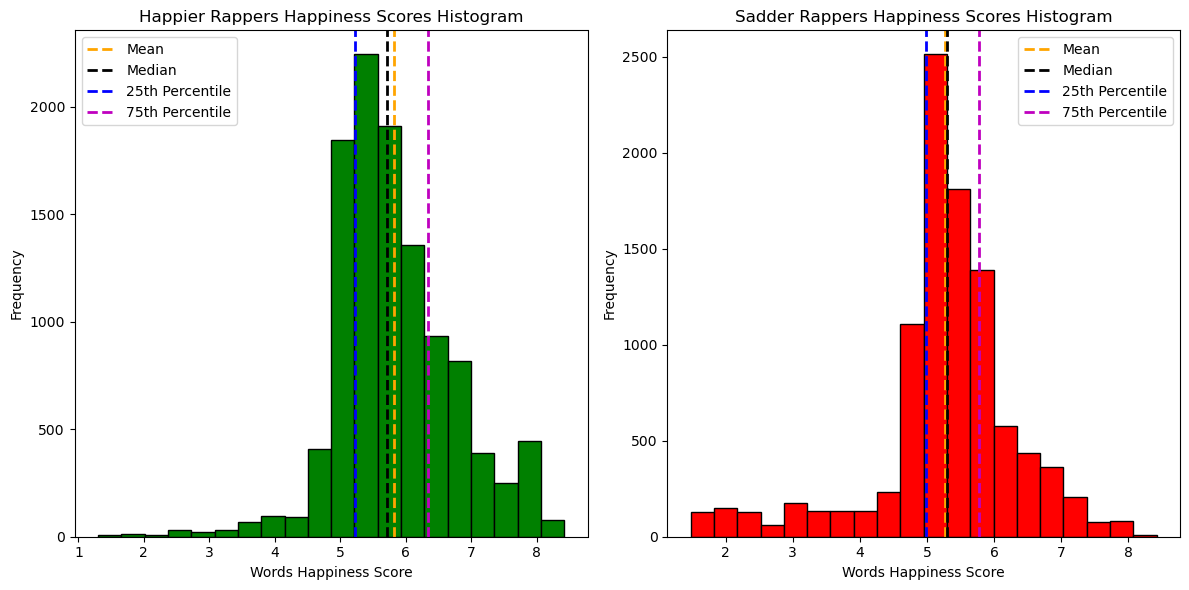

In [54]:
happy_scores = []

# Iterate through the rappers and their word dictionaries
for rapper in happiest_rappers:
    words_dict = rapper[1]['words_dict']
    for word, word_data in words_dict.items():
        happiness_score = word_data['happiness_score']
        frequency = word_data['frequency']
        happy_scores.extend([happiness_score] * frequency)


sad_scores = []


# Iterate through the rappers and their word dictionaries
for rapper in saddest_rappers:
    words_dict = rapper[1]['words_dict']
    for word, word_data in words_dict.items():
        happiness_score = word_data['happiness_score']
        frequency = word_data['frequency']
        sad_scores.extend([happiness_score] * frequency)




# Calculate the mean, median, and percentiles for happy_scores and sad_scores
mean_happy = round(np.mean(happy_scores),2)
median_happy = np.median(happy_scores)
percentiles_happy = np.percentile(happy_scores, [25, 75])

mean_sad = round(np.mean(sad_scores),2)
median_sad = np.median(sad_scores)
percentiles_sad = np.percentile(sad_scores, [25, 75])

# Print the statistics for happier rappers
print("Happier Rappers Statistics:")
print(f"Mean: {mean_happy}")
print(f"Median: {median_happy}")
print(f"25th Percentile: {percentiles_happy[0]}")
print(f"75th Percentile: {percentiles_happy[1]}")

# Create two histograms
plt.figure(figsize=(12, 6))

# Happier happiness scores histogram
plt.subplot(1, 2, 1)
plt.hist(happy_scores, bins=20, edgecolor='black', color='green')
plt.title("Happier Rappers Happiness Scores Histogram")
plt.xlabel("Words Happiness Score")
plt.ylabel("Frequency")

# Add vertical lines for mean, median, and percentiles for happy_scores
plt.axvline(mean_happy, color='orange', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_happy, color='black', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(percentiles_happy[0], color='b', linestyle='dashed', linewidth=2, label='25th Percentile')
plt.axvline(percentiles_happy[1], color='m', linestyle='dashed', linewidth=2, label='75th Percentile')

# Display a legend
plt.legend()

# Print the statistics for sadder rappers
print("\nSadder Rappers Statistics:")
print(f"Mean: {mean_sad}")
print(f"Median: {median_sad}")
print(f"25th Percentile: {percentiles_sad[0]}")
print(f"75th Percentile: {percentiles_sad[1]}")

# Sad happiness scores histogram
plt.subplot(1, 2, 2)
plt.hist(sad_scores, bins=20, edgecolor='black', color='red')
plt.title("Sadder Rappers Happiness Scores Histogram")
plt.xlabel("Words Happiness Score")
plt.ylabel("Frequency")

# Add vertical lines for mean, median, and percentiles for sad_scores
plt.axvline(mean_sad, color='orange', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_sad, color='black', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(percentiles_sad[0], color='b', linestyle='dashed', linewidth=2, label='25th Percentile')
plt.axvline(percentiles_sad[1], color='m', linestyle='dashed', linewidth=2, label='75th Percentile')

# Display a legend
plt.legend()

plt.tight_layout()
plt.show()


Fig : The figure ilustrates the distribution os words hapiness scores (present on wikipedia page) for the 10 happiest rappers (on the left) and the 10 saddest (on the right).


**Answer**:

At the tables X and Y, we can see that the word 'music', with an average score of 8.02 appear 28 and 21 times for Young Music DYMG and V. Rose, respectively (2nd and 3rd happier pages) and for example the word 'death' with 1.54 appears 12 times for the saddest rapper, Ol' Dirty Bastard, that shows us how words appear in each set.

We can also notice that the happiest rapper has a page length of 13 so it is not completely fair to compare the average score with pages with more text, that would probabily have more neutral words that can push down the average score (or up, if we are comparing the saddest rappers). 

With fig. we conclude that the happiest rappers wikipedia pages have more words with scores distributed in a happier range (between 5.2 and 6.3), and with few cases where words have sad sentiments, what happens with the saddest rappers wikipedia pages is that they have significantly more words with sad feelings.



Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).


In [31]:
import numpy as np

# Calculate the average sentiment for each coast
average_sentiments_west = []
average_sentiments_east = []

for node in G.nodes():
    sentiment = G.nodes[node]['average_sentiment']
    coast = G.nodes[node]['coast']
    
    if sentiment != 0:  # Disregard rappers with sentiment 0
        if coast == 'west':
            average_sentiments_west.append(sentiment)
        elif coast == 'east':
            average_sentiments_east.append(sentiment)

# Determine the happiest and saddest coast
west_sentiment=np.mean(average_sentiments_west)
east_sentiment=np.mean(average_sentiments_east)

happiest_coast = 'west coast' if west_sentiment > east_sentiment else 'east coast'


# Print the results
print(f'West sentiment: {west_sentiment}')
print(f'East sentiment: {east_sentiment}')
print(f'So in this case the happiest coast is: {happiest_coast}')



West sentiment: 5.558594287801437
East sentiment: 5.554474561327298
So in this case the happiest coast is: west coast


> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

In [70]:
### Setting Up Variables:
if happiest_coast=='west coast':
    num_happiest_coast_rappers=len(average_sentiments_west)
else:
    num_happiest_coast_rappers=len(average_sentiments_east)


num_samples = 1000

all_sentiments = [data['average_sentiment'] for _, data in G.nodes(data=True) if 'average_sentiment' in data and data['average_sentiment'] != 0]  # All non-zero sentiments in the graph


### Running the Label Shuffling Test:
if happiest_coast=='west coast':
    average_sentiments_happiest_coast=west_sentiment
else:
    average_sentiments_happiest_coast=east_sentiment


count = 0
for _ in range(num_samples):
    random_sentiments = random.sample(all_sentiments, num_happiest_coast_rappers)
    if sum(random_sentiments) / len(random_sentiments) > average_sentiments_happiest_coast:
        count += 1

### Calculating and Interpreting the P-value:

p_value = count / num_samples
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The happiest coast has a significantly higher sentiment than a randomly selected group of rappers.")
else:
    print("There is no significant difference in sentiment between the happiest coast and a randomly selected group of rappers.")



P-value: 0.292
There is no significant difference in sentiment between the happiest coast and a randomly selected group of rappers.


**Answer**:

We had a p-value bigger than the confidence bound of 5%, so we do not have sufficent statiscal evidence to aprove the hypothesis that "the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size".
In this way, we can say that the higher average sentiment observed for the happiest coast could very well have occurred by random chance, in other words we cannot afirm that the rappers of the west coast (happiest coast) are more happier compared to the other rappers.

# References

[1] Python Regular Expressions. Accessed: Oct. 25, 2023. [Online]. Available: https://developers.google.com/edu/python/regular-expressions

                
                
[ex] Network Science by Albert-László Barabási - Chapter 3: equation (3.3). Accessed: Sep. 25, 2023. [Online]. Available: http://networksciencebook.com/  